In [6]:
from ATM_waveform.make_rx_scat_catalog import make_rx_scat_catalog
from ATM_waveform.waveform import waveform
import h5py
import numpy as np
import matplotlib.pyplot as plt
from ATM_waveform.scat_fit_errors import plot_scat_fit_error

The system IRF can be characterized in three ways:

--Internal calibration data from the delay line

--Reflected waveforms from  surfaces with little subsurface scattering

--Ground calibration tests

I have precomputed calibration estimates from ground-test waveforms from the spring and fall of 2018, and a delay-line transmit waveform can be calculated from any ATM waveform file:

In [8]:
with h5py.File('/Data/ATM_WF/GroundTest/Fall18/NarrowSwathTx.h5','r') as h5f:
    TX_fall=waveform(np.array(h5f['/TX/t']), np.array(h5f['TX/p']))
with h5py.File('/Data/ATM_WF/GroundTest/Spring18/NarrowSwathTx.h5','r') as h5f:
    TX_spring=waveform(np.array(h5f['/TX/t']), np.array(h5f['TX/p']))
from ATM_waveform.fit_ATM_scat import get_tx_est
TX_delay_fall=get_tx_est('/Data/ATM_WF/GroundTest/Fall18/ILATMW1B_20181002_151220.atm6AT6.h5', nShots=500)[0]

     time to fit start pulse=1.614


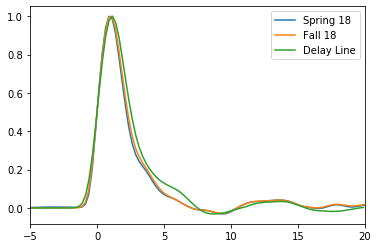

In [9]:
plt.plot(TX_spring.t-TX_spring.t50(), TX_spring.p, label='Spring 18')
plt.plot(TX_fall.t-TX_fall.t50(), TX_fall.p, label='Fall 18')
plt.plot(TX_delay_fall.t-TX_delay_fall.t50(), TX_delay_fall.p, label='Delay Line')
plt.gca().set_xlim([-5, 20]); plt.legend()

These three examples are plotted with t=0 at the first 50% threshold crossing for each waveform.  The ground-test transmit-pulse estimates all look similar, but are significantly narrower than the delay-line estimates.  

Waveform fitting works by matching (in a least-squares sense) measured waveforms with modeled waveforms.  The model waveform is a system impulse-response waveform estimate (IRF), convolved with a surface-response function (SRF) from a Monte Carlo subsurface scattering model with a specified $r_{eff}$, convolved with a surface roughness model with a specified $\sigma$:
\begin{equation}
    WF_{model}= A \cdot SRF(t-t_0, t^\prime, r_{eff}) \times IRF (t^\prime) \times G(t^\prime, 0,\sigma) 
\end{equation}

Adjusting the $t_0$ parameter in the SRF allows the waveform to be shifted to match the return waveform, and the $A$ parameter adjusts its amplitude.

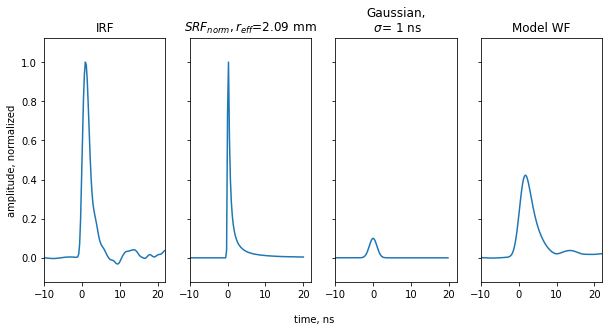

In [11]:
from ATM_waveform.fit_waveforms import gaussian, listDict
SRF_file='/Users/ben/git_repos/IS2_calval/SRF_green_full.h5'
impulse_catalog=make_rx_scat_catalog(TX_spring, h5_file=SRF_file)
r_vals=[X for X in impulse_catalog.keys()]
twomm=np.argmin(np.abs(np.array(r_vals)-0.002))
fig, ax=plt.subplots(1,4, sharex=True, sharey=True, figsize=[10,4.5])
plt.sca(ax[0])
plt.plot(TX_spring.t-TX_spring.t50(), TX_spring.p); 
plt.title('IRF');plt.ylabel('amplitude, normalized')
plt.sca(ax[1])
with h5py.File(SRF_file,'r') as h5f:
    p_SRF=np.array(h5f['p'][twomm,:])
    plt.plot(np.array(h5f['t'])*1.e9, p_SRF/(1*np.max(p_SRF)))
plt.title('$SRF_{norm}, r_{eff}$=%3.2f mm' % (np.float64(r_vals[twomm])*1000)); 
plt.sca(ax[2])
tK=np.arange(-20, 20, 0.25); K=gaussian(tK, 0, 1); K/=K.sum()
plt.plot(tK, K)
plt.title('Gaussian,\n $\sigma$= 1 ns')
plt.sca(ax[3])
model_WF=waveform(impulse_catalog[r_vals[-1]].t, np.convolve(impulse_catalog[r_vals[twomm]].p.ravel(), K.ravel(),'same'))
plt.plot(model_WF.t-model_WF.t50(), model_WF.p, label='RX_{est}, r_eff=%3.2f mm' % (r_vals[-20]))
plt.title('Model WF')
ax[3].set_ylim([-0.125, 1.125])
ax[3].set_xlim([-10, 22])
_=fig.text(0.5, 0., 'time, ns', ha='center')

Here we show the three components that make up a model waveform: the impulse-response function, the SRF, and the surface roughness.  The model return waveform is broader and smoother than the IRF, mainly because each subsequent step in the model results in energy being spread from the sharp peak of the SRF.  The difference in peak amplitude would not be independently observable in real return data, unless the radiometric response of the instrument is well characterized, but it should be observable in a relative sense between surfaces with large and small subsurface scattering delays. 

Text(0, 0.5, 'misfit')

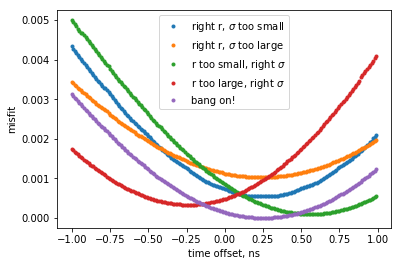

In [46]:
from IS2_calval.fit_waveforms import broadened_misfit
impulse_catalog.update({0:TX_spring})
catalog=listDict()
# set up the waveform catalog
for key in impulse_catalog:
    catalog[[key]]=waveform(impulse_catalog[key].t.copy(), impulse_catalog[key].p.copy())
# define a plotting function
def misfit_plot(sigma, reff, model_WF, catalog, name):
    M=listDict()
    delta_ts=np.arange(-1, 1, 0.01)
    _=broadened_misfit(delta_ts, sigma, model_WF, catalog, M, [reff],  t_tol=0.1)
    Rcurve=np.array([ [M[X]['delta_t'], M[X]['R']] for X in M.keys() if 'delta_t' in M[X]])
    plt.plot(Rcurve[:,0], Rcurve[:,1],'.', label=name)
misfit_plot(0, r_vals[twomm], model_WF, catalog, 'right r, $\sigma$ too small')
misfit_plot(2, r_vals[twomm], model_WF, catalog, 'right r, $\sigma$ too large')
misfit_plot(1., r_vals[twomm-10], model_WF, catalog, 'r too small, right $\sigma$')
misfit_plot(1., r_vals[twomm+10], model_WF, catalog, 'r too large, right $\sigma$')
misfit_plot(1., r_vals[twomm], model_WF, catalog, 'bang on!')
plt.legend()
plt.xlabel('time offset, ns')
plt.ylabel('misfit')

This plot illustrates the fitting process: We try a series of $r_{eff}$ values; for each $r_{eff}$ we search a raneg of $\sigma$ values; for each $\sigma$ value we search a range of $\delta t$ values, and for each $\delta t$ value we perform a least-squares for for A.  (whew!)

In [3]:
output_file='/Data/ATM_WF/GroundTest/Fall18/NarrowSwathTX_FittingError.h5'

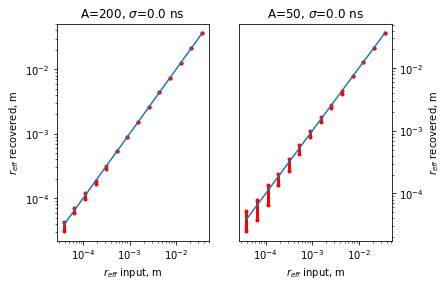

In [23]:
fig,ax=plt.subplots(1,2)
plot_scat_fit_error(output_file, A_val=200, sigma_val=0, ax=ax[0])
plot_scat_fit_error(output_file, A_val=50, sigma_val=0, ax=ax[1])
ax[1].yaxis.set_ticks_position('right')
ax[1].yaxis.set_label_position('right')

As long as $\sigma$ is small, we see good recovery of $r_{eff}$ down to very small grain sizes.  Errors are larger at low SNR values

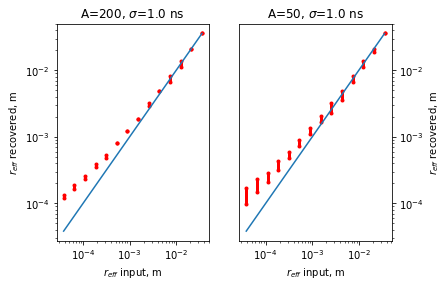

In [22]:
fig,ax=plt.subplots(1,2)
plot_scat_fit_error(output_file, A_val=200, sigma_val=1, ax=ax[0])
plot_scat_fit_error(output_file, A_val=50, sigma_val=1, ax=ax[1])
ax[1].yaxis.set_ticks_position('right')
ax[1].yaxis.set_label_position('right')

The fitting process starts to produce significant biases in the recovery for $\sigma$ > 1; stronger SNR produes similar bias magnitudes, but smaller scatter.

['OFFSETTEXTPAD',
 '__class__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__getstate__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__lt__',
 '__module__',
 '__name__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 '_agg_filter',
 '_alpha',
 '_animated',
 '_autolabelpos',
 '_axes',
 '_clipon',
 '_clippath',
 '_contains',
 '_copy_tick_props',
 '_get_label',
 '_get_offset_text',
 '_get_pixel_distance_along_axis',
 '_get_tick',
 '_get_tick_bboxes',
 '_get_tick_boxes_siblings',
 '_gid',
 '_gridOnMajor',
 '_gridOnMinor',
 '_in_layout',
 '_label',
 '_major_tick_kw',
 '_minor_tick_kw',
 '_mouseover',
 '_oid',
 '_path_effects',
 '_picker',
 '_prop_order',
 '_propobservers',
 '_rasterized',
 '_remove_method',
 '_scale',
 '_set_artist_props',
 '_set_gc_clip',
 '_set_scale',
 '_sketch',
 '_smart_